In [176]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [265]:
cancer_df = pd.read_csv('CANCER_TABLE.csv')
diameter_column_name ='diameter (cm)'
true_column_name = ' cancer'
predicted_model_1_column_name = 'predicted_model_1'
predicted_model_2_column_name = 'predicted_model_2'
predicted_best_model_column_name = 'predicted_best_model'

In [149]:
def model1(input)->bool:
    if input[diameter_column_name] > 7:
        return True
    else:
        return False

In [150]:
result = cancer_df.apply(model1, axis=1)
cancer_df[predicted_model_1_column_name] = result

In [151]:
cancer_confusion_matrix = confusion_matrix(cancer_df[true_column_name], cancer_df[predicted_model_1_column_name])

In [152]:
cancer_confusion_matrix

array([[689, 118],
       [  0, 193]])

In [153]:
TN = cancer_confusion_matrix[0][0]
FN = cancer_confusion_matrix[1][0]
TP = cancer_confusion_matrix[1][1]
FP = cancer_confusion_matrix[0][1]
print('TN:', TN)
print('FN:', FN)
print('TP:', TP)
print('FP:', FP)

TN: 689
FN: 0
TP: 193
FP: 118


If we look at our confusion matrix, we can see the model does predict most samples correctly. If we look at the weaknesses of the model, we can see a high false positive score, which means that people that didn't get cancer will be labeled with a high chance to develop one in the next year. On the counterside, we see that the false negative score is 0, which means the model will not mistakenly label people that have a high chance of developing cancer as people that have a low chance of developing cancer.


In [154]:
print('TPR: ', TN / (TN + FN))
print('FPR: ', FP / (FP + TN))

TPR:  1.0
FPR:  0.14622057001239158


We can see out TPR is equal to 1, a perfect score! This means that when people with a high risk of developing cancer get a test result indicating they have a high risk of developing cancer, the test is correct with a very high chance.

We can also see the FPR is very low, this is also good. This means we have a good false positive score-true negative ratio. In simple words, this means most people that get a result indicating they have a low chance of developing cancer, actually do have a low rate of developing cancer.

In [155]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = (TP)/(TP+FN)
precision = (TP)/(TP+FP)
F1 = 2*recall*precision/(recall+precision)

In [156]:
print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1: ', F1)

Accuracy:  0.882
Recall:  1.0
Precision:  0.6205787781350482
F1:  0.7658730158730159


In [157]:
diameters_sorted = (pd.Series(cancer_df[diameter_column_name].sort_values(ascending=True).values))

def model2(input):
    return diameters_sorted.searchsorted(input[diameter_column_name])/diameters_sorted.size

In [159]:
result = cancer_df.apply(model2, axis=1)
cancer_df[predicted_model_2_column_name] = result

This model can be better because it allows us as data scientists to choose a threshold that maximizes the customer's target. For example, if the customer is more concerned about FP we might choose a threshold that maximizes the recall.

In [255]:
thresholds = np.arange(0, 1, 0.01)
all_TPRs = []
all_FPRs = []
youdens_index = {}
probabilities = cancer_df[predicted_model_2_column_name]
true_labels = cancer_df[true_column_name]
for threshold in thresholds:
    predictions = probabilities.apply(lambda x: True if x >= threshold else False)
    cancer_confusion_matrix = confusion_matrix(true_labels, predictions)

    TN = cancer_confusion_matrix[0][0]
    FN = cancer_confusion_matrix[1][0]
    TP = cancer_confusion_matrix[1][1]
    FP = cancer_confusion_matrix[0][1]

    TPR = TP/(TP + FN) if TP+FN!=0 else 0
    FPR = FP/(FP + TN) if FP+TN!=0 else 0

    all_TPRs.append(TPR)
    all_FPRs.append(FPR)
    youdens_index[threshold] = TPR-FPR

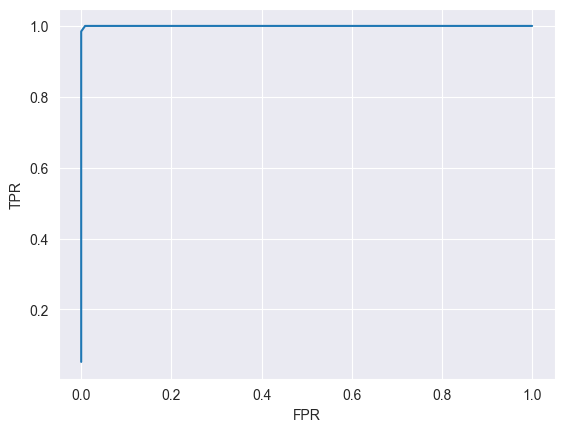

In [256]:
plt.plot(all_FPRs, all_TPRs)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [249]:
from sklearn.metrics import auc

print('AUC:',auc(all_FPRs, all_TPRs))

AUC: 0.9999325847025059


If we look at the AUC and the ROC curve, we can see almost a perfect ROC. This means choosing a good threshold is quite easy, we look at the top left corner, and take the threshold from there. Mathmetically, we calculate Youden's index, which is TPR-FPR, and take the maximum:

In [263]:
best_threshold = max(youdens_index, key=youdens_index.get)
print('Best Threshold:', best_threshold)

Best Threshold: 0.8


In [266]:
def best_model(input):
    probability = diameters_sorted.searchsorted(input[diameter_column_name])/diameters_sorted.size
    return probability>0.8

In [267]:
result = cancer_df.apply(best_model, axis=1)
cancer_df[predicted_best_model_column_name] = result

In [268]:
cancer_confusion_matrix = confusion_matrix(cancer_df[true_column_name], cancer_df[predicted_best_model_column_name])

In [269]:
cancer_confusion_matrix

array([[801,   6],
       [  0, 193]])

In [270]:
TN = cancer_confusion_matrix[0][0]
FN = cancer_confusion_matrix[1][0]
TP = cancer_confusion_matrix[1][1]
FP = cancer_confusion_matrix[0][1]
print('TN:', TN)
print('FN:', FN)
print('TP:', TP)
print('FP:', FP)

TN: 801
FN: 0
TP: 193
FP: 6


In [271]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = (TP)/(TP+FN)
precision = (TP)/(TP+FP)
F1 = 2*recall*precision/(recall+precision)

In [272]:
print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1: ', F1)

Accuracy:  0.994
Recall:  1.0
Precision:  0.9698492462311558
F1:  0.9846938775510203


This model is much better then the previous ones, all our matrics are better.

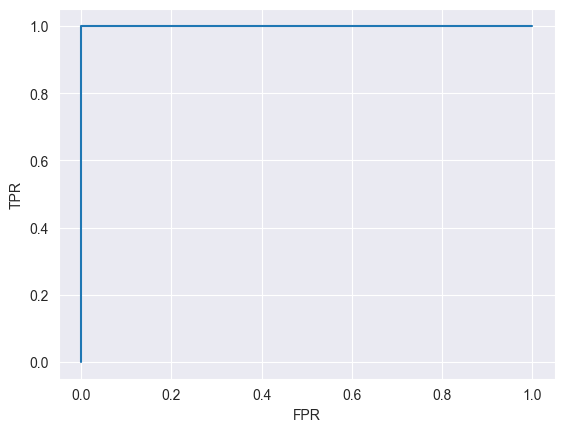

In [276]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, probabilities)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()